# **Predicting ADR with ARIMA Model**

In this report, an ARIMA model is developed to predict average daily rate (ADR).

In [1]:
#Import data manipulation library
import pandas as pd

#Import visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Import seasonal decomposition and sklearn metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from math import sqrt
from sklearn.metrics import mean_squared_error

#Filter/Ignore warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
#Load dataset and view head
df = pd.read_csv("hotel.csv")
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


After loading in the dataset, a new dataframe is created that contains only the columns that are relevant for developing the ARIMA model (‘adr’, ‘arrival_date_day_of_month’, ‘arrival_date_month’, and ‘arrival_date_year’).

In [3]:
#New dataframe 'df1'
df1 = df[['arrival_date_day_of_month', 'arrival_date_month', 'arrival_date_year', 'adr']]
df1.head()

,arrival_date_day_of_month,arrival_date_month,arrival_date_year,adr
0,1,July,2015,0.0
1,1,July,2015,0.0
2,1,July,2015,75.0
3,1,July,2015,75.0
4,1,July,2015,98.0


The month names in ‘arrival_date_month’ are converted to month numbers to allow the ARIMA model to recognise the order and cyclical nature of months. In addition, the ‘arrival_date_year’, ‘arrival_date_month’, and ‘arrival_date_day_of_month’ are concatenated to date format as ARIMA models rely on time series data.

In [4]:
#Convert month names to month numbers
df1['arrival_month'] = pd.to_datetime(df.arrival_date_month, format = '%B').dt.month

#Concatenate and convert all arrival columns to date format
df1['arrival_date'] = pd.to_datetime(df1['arrival_date_year'].map(str) + "-" + df1['arrival_month'].map(str) + "-" + df1['arrival_date_day_of_month'].map(str), format = '%Y-%m-%d')

#View head
df1.head()

,arrival_date_day_of_month,arrival_date_month,arrival_date_year,adr,arrival_month,arrival_date
0,1,July,2015,0.0,7,2015-07-01
1,1,July,2015,0.0,7,2015-07-01
2,1,July,2015,75.0,7,2015-07-01
3,1,July,2015,75.0,7,2015-07-01
4,1,July,2015,98.0,7,2015-07-01


In [5]:
#New dataframe
df2 = df1[['arrival_date', 'adr']]
df2.head()

,arrival_date,adr
0,2015-07-01,0.0
1,2015-07-01,0.0
2,2015-07-01,75.0
3,2015-07-01,75.0
4,2015-07-01,98.0


In [6]:
#Examine summary statistics
df2.describe()

,adr
count,119390.000000
mean,101.831122
std,50.535790
min,-6.380000
25%,69.290000
50%,94.575000
75%,126.000000
max,5400.000000


In [7]:
#Sort 'adr' values
df2.sort_values('adr')

,arrival_date,adr
14969,2017-03-05,-6.38
0,2015-07-01,0.00
2534,2015-10-21,0.00
2536,2015-10-21,0.00
33283,2017-02-18,0.00
...,...,...
13142,2017-08-01,450.00
103912,2016-12-31,451.50
15083,2015-07-15,508.00
111403,2017-05-09,510.00


Before building the ARIMA model, the negative value (-6.38) in row 14,969 needs to be replaced with 6.38 (non-negative) and the outlier (5,400) in row 48,515 needs to be capped at the highest extreme value (510). This is done to improve the performance of the ARIMA model and to ensure accurate predictions.

In [8]:
#Replacing negative value with 6.38
df2.loc[df2['adr'] == -6.38, 'adr'] = 6.38
df2.loc[14969]

arrival_date    2017-03-05 00:00:00
adr                            6.38
Name: 14969, dtype: object

In [9]:
#Capping outlier at 510
df2.loc[df2['adr'] > 510, 'adr'] = 510
df2.loc[48515]

arrival_date    2016-03-25 00:00:00
adr                           510.0
Name: 48515, dtype: object

Next, the distribution of 'adr' is visualised using a boxplot to understand the spread and central tendency of the data and to examine potential outliers. While the boxplot shows that there are still extreme values present in 'adr', these values do not deviate too significantly like the outlier addressed earlier. Furthermore, these values may be genuine adr values, and therefore, are left as is.

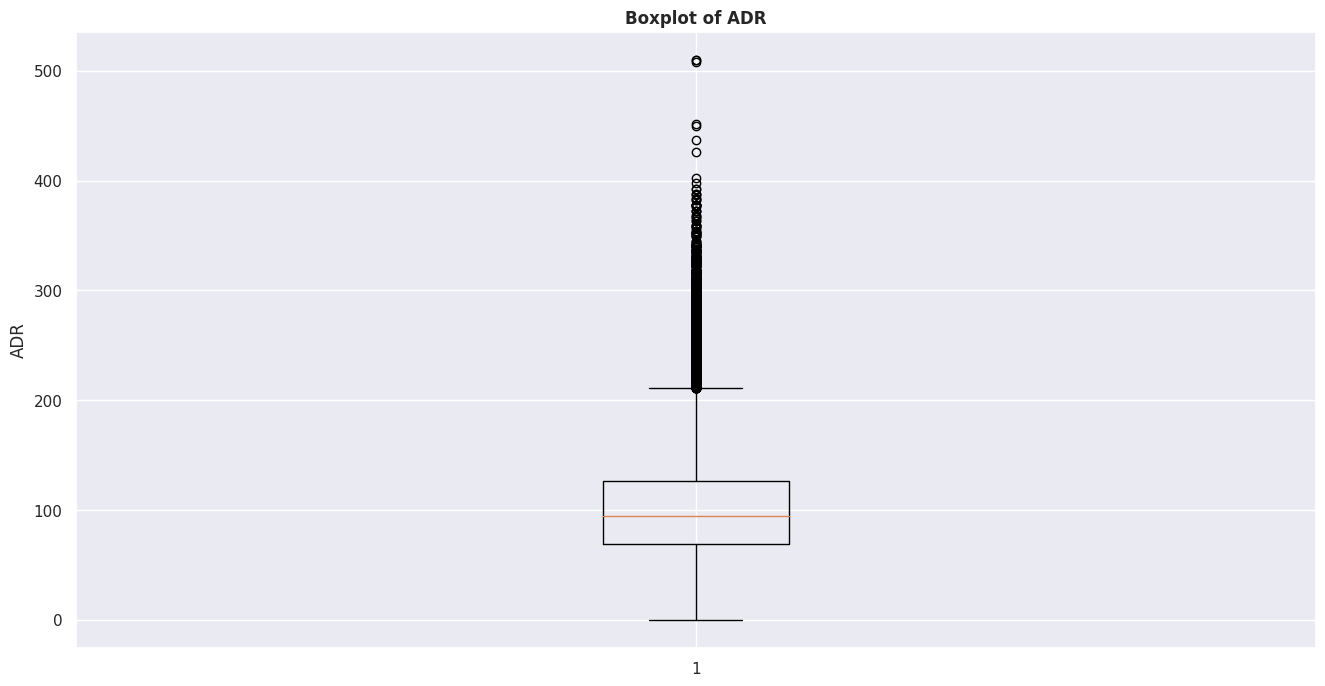

In [10]:
#Create boxplot
sns.set()
plt.figure(figsize = (16, 8))
plt.boxplot(df2['adr'])
plt.title('Boxplot of ADR', fontweight = 'bold')
plt.ylabel('ADR')
plt.show()

Before building the model, the 'adr' column is visualised. The plotted graph shows ‘adr’ fluctuations on a daily basis; however, plotting all these values leads to a cluttered and difficult to interpret plot.

In [11]:
#Set datetime axis
df2.index = pd.to_datetime(df2['arrival_date'], format = '%Y-%m-%d')

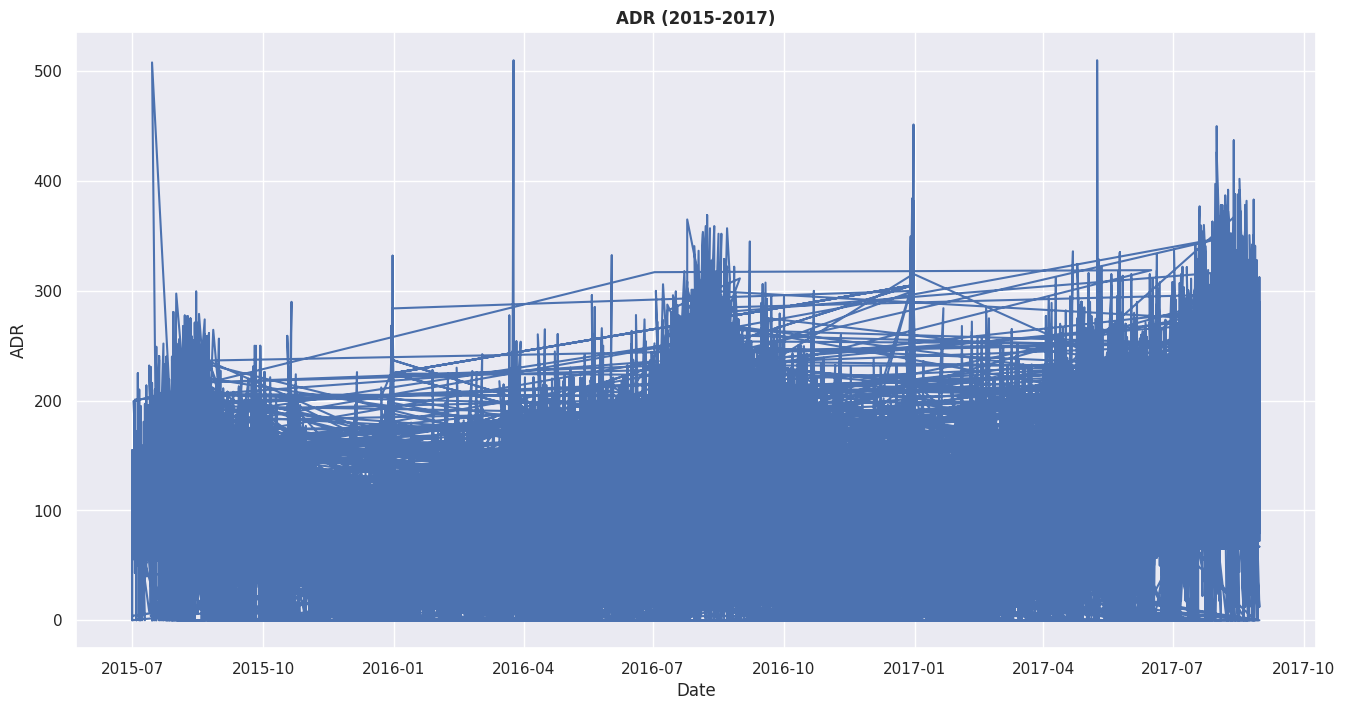

In [12]:
#Visualise ADR
sns.set()
plt.figure(figsize = (16, 8))
plt.plot(df2.index, df2['adr'])
plt.ylabel('ADR')
plt.xlabel('Date')
plt.title('ADR (2015-2017)', fontweight = 'bold')
plt.show()

Consequently, the dataset is resampled on a weekly basis, which ensures regular intervals while also facilitating smoother visualisation and interpretation of trends in the data. Additionally, resampling by week can potentially reveal trends and seasonal variations within the data.

In [13]:
#Resample data on a weekly basis
rdata = df2.resample("W").mean()
rdata.head()

,adr
arrival_date,
2015-07-05,90.397743
2015-07-12,94.156404
2015-07-19,101.486901
2015-07-26,97.092084
2015-08-02,114.554399


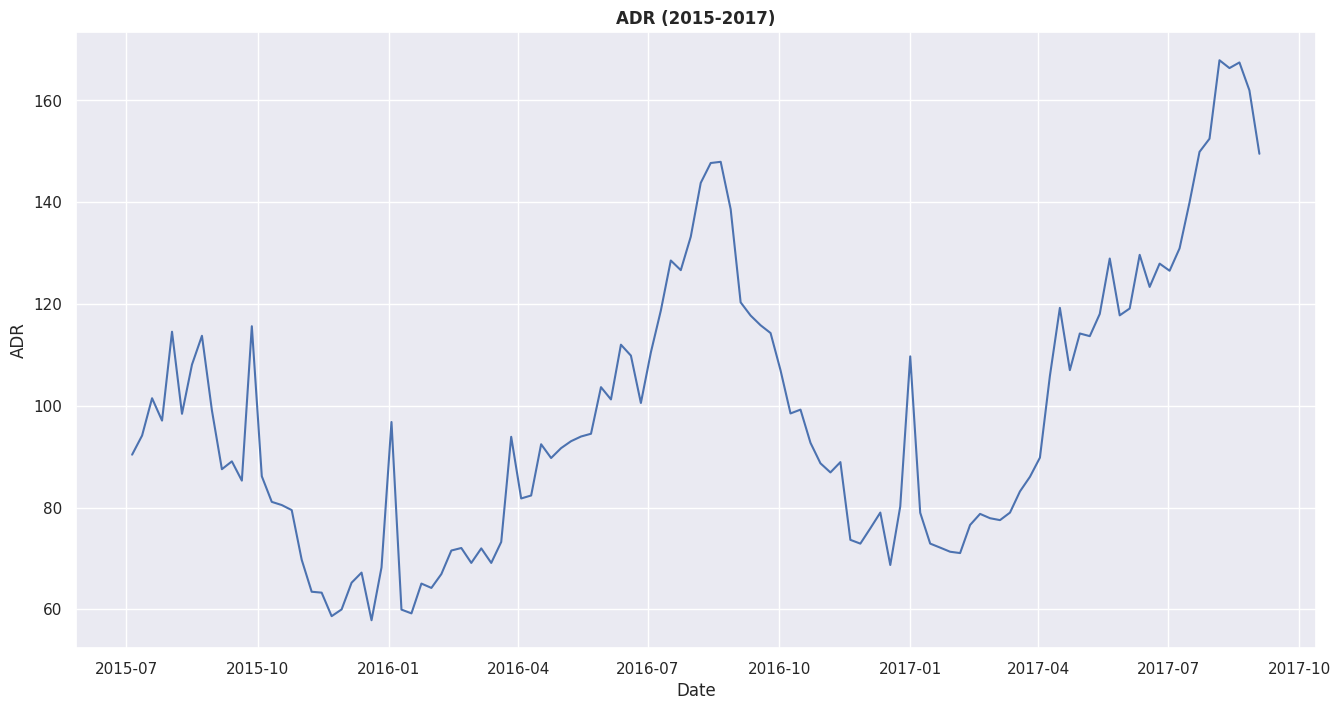

In [14]:
#Visualise resampled data
sns.set()
plt.figure(figsize = (16, 8))
plt.plot(rdata.index, rdata['adr'])
plt.ylabel('ADR')
plt.xlabel('Date')
plt.title('ADR (2015-2017)', fontweight = 'bold')
plt.show()

Furthermore, the code shown below is used to perform time series decomposition of the 'adr' column using the additive model. The decomposition seperates the times series data into trend, seasonal, and residual components, which allows for a better understanding of the underlying patterns in the data. As evidenced by the generated plot, there appears to be yearly seasonality in the data, as adr rises on the first month of every year and also peaks around the eigth or ninth month each year. This must be considered when developing the ARIMA model.

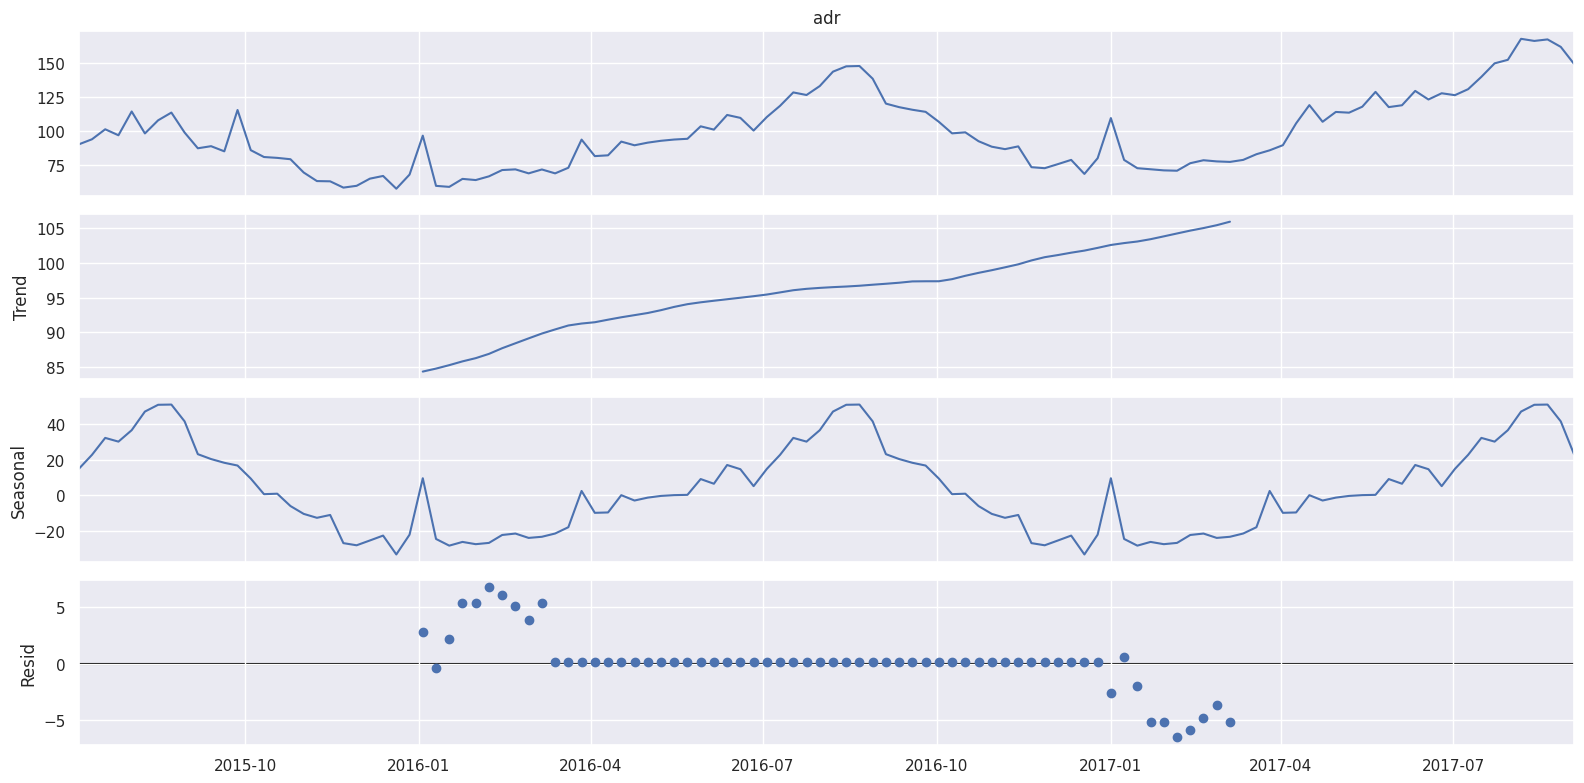

In [15]:
#Explore seasonal decomposition
sns.set()
plt.rcParams['figure.figsize'] = [16, 8]
decomposition = seasonal_decompose(rdata["adr"], model = "additive")
decomposition.plot()
plt.show()

Following data exploration, the data is split into training and validation sets to facilitate model training and evaluation. The split data is then visualised.

In [16]:
#Split data into training and validation sets
train = rdata[rdata.index < pd.to_datetime("2017-05-01", format = '%Y-%m-%d')]
valid = rdata[rdata.index > pd.to_datetime("2017-05-01", format = '%Y-%m-%d')]

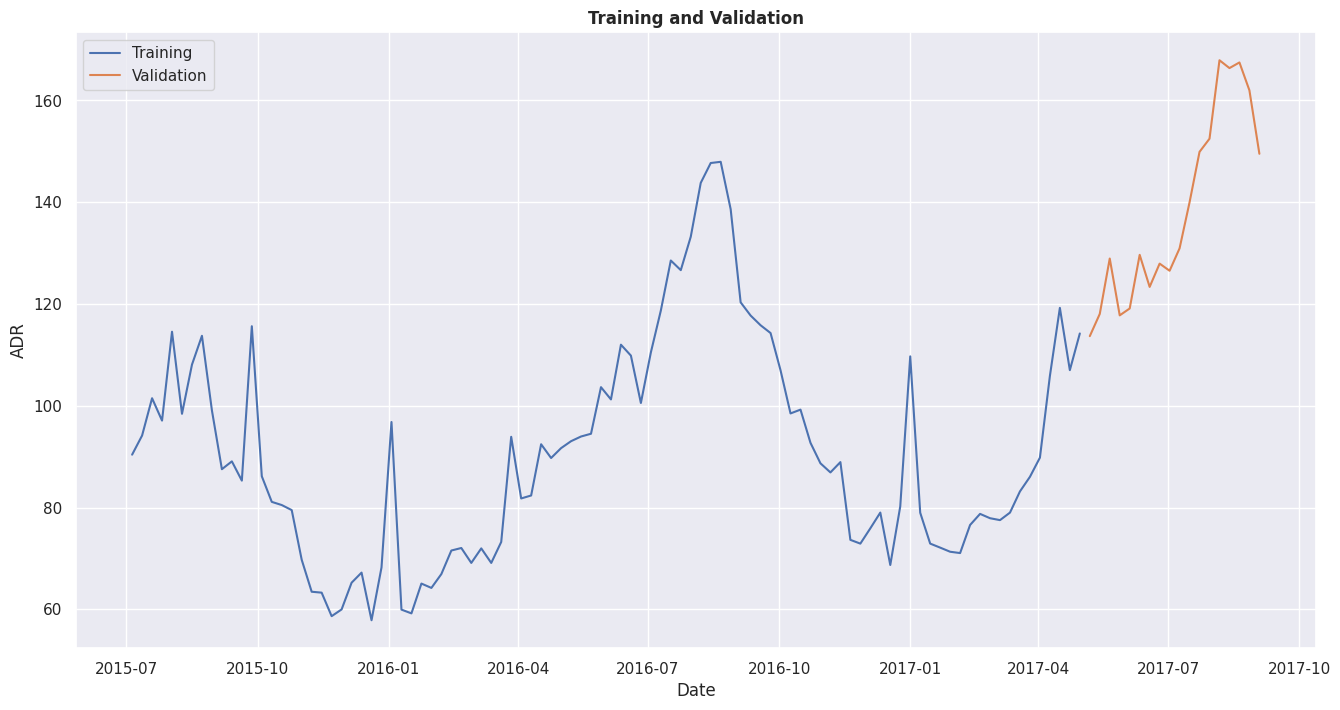

In [17]:
#Visualise training and validation sets
plt.figure(figsize = (16, 8))
plt.plot(train['adr'], label = 'Training')
plt.plot(valid['adr'], label = 'Validation')
plt.ylabel('ADR')
plt.xlabel('Date')
plt.title('Training and Validation', fontweight = 'bold')
plt.legend()
plt.show()

Finally, the auto ARIMA model is built using 'arrival_date' and 'adr'. 'Seasonal' is set as 'True' and the value for 'm', which is "the period for seasonal differencing" is set to 52 as the data is recorded in weekly intervals and exhibits yearly seasonality (Smith, 2017). Setting 'm=52' enables the model to capture weekly seasonal patterns in the data.

In [18]:
#Model development
! pip install pmdarima

from pmdarima.arima import auto_arima
model = auto_arima(train['adr'], start_p=0, start_q=0,
                      test='adf',
                      max_p=10, max_q=10,
                      m=52,
                      d=1,
                      seasonal=True,
                      start_P=0,
                      D=1,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=319.316, Time=10.04 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=317.318, Time=0.45 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=10.81 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=12.14 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=8.60 sec
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=inf, Time=7.23 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=313.306, Time=0.28 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=10.59 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=317.301, Time=14.03 sec
 ARIMA(2,1,0)(0,1,0)[52]             : AIC=313.348, Time=0.56 sec
 ARIMA(1,1,1)(0,1,0)[52]             : AIC=312.799, Time=0.53 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=314.794, Time=16.80 sec
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=inf, Time=13.58 sec
 ARIMA(1,1,1)(1,1,1)[52]             : AIC=316.794, Time=17.79 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=310.99

Comparing predicted ADR values to actual ADR values shows that the model underestimates actual ADR values for the validation set.

In [19]:
#Examine model predictions for ADR
prediction = pd.DataFrame(model.predict(n_periods = len(valid)))
prediction.index = valid.index
prediction.columns = ["predict"]
prediction.head()

,predict
arrival_date,
2017-05-07,113.799679
2017-05-14,114.720329
2017-05-21,115.263777
2017-05-28,124.415544
2017-06-04,122.006417


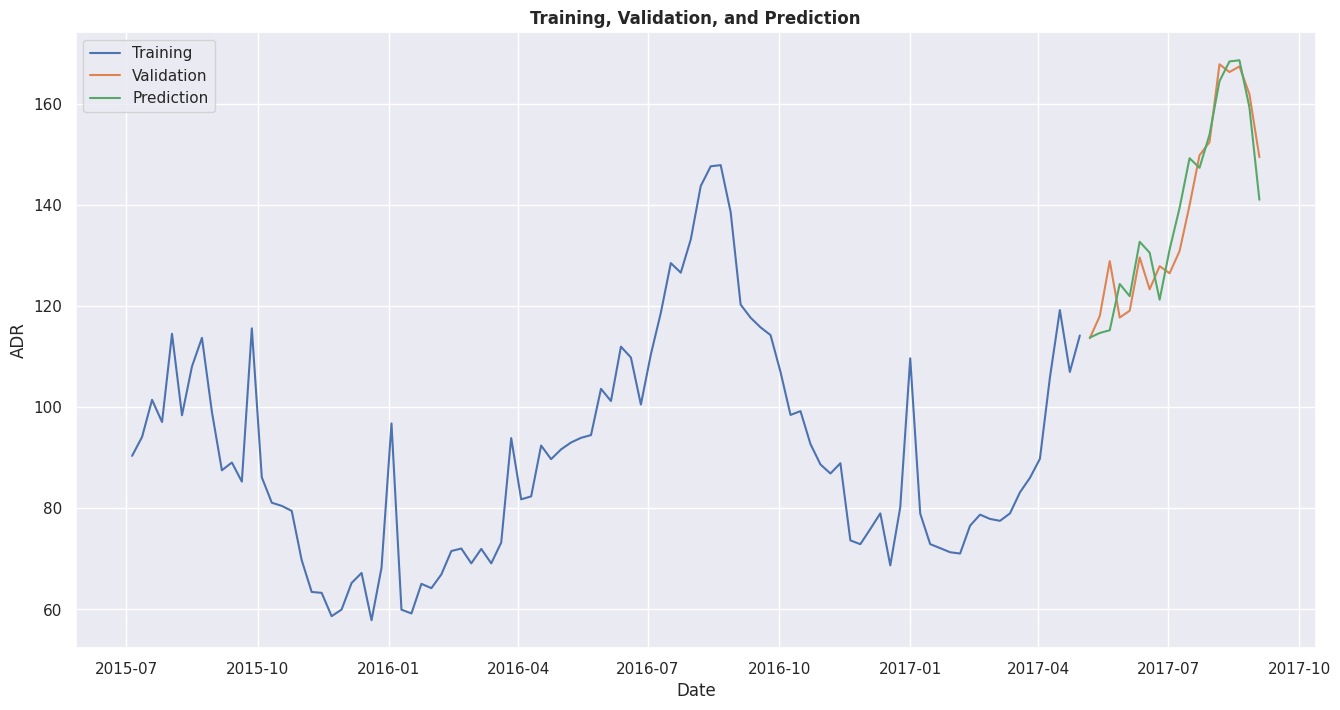

In [20]:
#Visualise the difference between the validation set and model predictions
plt.figure(figsize = (16, 8))
plt.plot(train['adr'], label = 'Training')
plt.plot(valid['adr'], label = 'Validation')
plt.plot(prediction['predict'], label = 'Prediction')
plt.ylabel('ADR')
plt.xlabel('Date')
plt.title('Training, Validation, and Prediction', fontweight = 'bold')
plt.legend()
plt.show()

While the plot visualised the difference between the validation set and the model predictions, a more accurate assessment is necessary. The statistical metric Root Mean Square Error (RMSE) can be used to evaluate the performance and predictive accuracy of the model. A lower RMSE value would indicate better model performance while a higher RMSE value would indicate poor performance. Overall, using RMSE to evaluate the performance of the ARIMA model provides insights into how well the model captures the underlying patterns and seasonal variations in the data.

In [21]:
#Calculate RMSE
RMSE = sqrt(mean_squared_error(valid, prediction))
print('RMSE:', RMSE)

RMSE: 5.972798618410142


An RMSE of 5.97 indicates that the ARIMA model has an average error of approximately 5.97 units when predicting ADR. As mentioned earlier, lower RMSE values indicate better model performance in terms of accuracy. In this case, a RMSE of 5.97 suggests that the ARIMA model developed to predict ADR provides reasonably accurate predictions, though it may be necessary to investigate model improvement strategies to improve performance and predictive accuracy.